In [1]:
import matplotlib

In [3]:
%matplotlib

Using matplotlib backend: <object object at 0x7f91a5e193b0>


In [ ]:
%matplotlib tk
matplotlib.use('TkAgg')

In [8]:
%matplotlib inline

In [2]:
# %matplotlib qt
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import pylab as plt
import blimpy
from blimpy import Waterfall
from blimpy import calcload
import os
import glob
import numpy as np
import time
from scipy.stats import norm, kurtosis, kurtosistest
import scipy
import numpy.ma as ma
import seaborn as sns

import sys
file_path = '/lustre/aoc/students/jsofair/playing-with-cosmic-data/filterbank/'
sys.path.insert(1, file_path[:54])
from analysis_functions import plot_tavg_power

In [3]:
file_list = glob.glob(os.path.join(file_path,'*.fil'))

ml_list = []
for i, file in enumerate(file_list):
    ml = blimpy.calcload.calc_max_load(os.path.join(file))
    ml_list.append(ml)
    print(f'{ml} -- {file[65:]}')

11.0 -- band_test_AC_CO-beam0001.fil
9.0 -- Band_Test_BD_C512-beam0001.fil
9.0 -- band_test_AC_C512-beam0001.fil
11.0 -- Band_Test_BD_C0-beam0001.fil
7.0 -- band_test_GPU3_BD_C32-beam0001.fil
11.0 -- band_test_AC_C32-beam0001.fil
4.0 -- band_test_AC_C544-beam0001.fil


In [4]:
t0=time.time()

water6 = Waterfall(os.path.normpath(file_list[6]), max_load = ml_list[6])


# water0 = Waterfall(os.path.normpath(file_list[0]), max_load = ml_list[0])
# water1 = Waterfall(os.path.normpath(file_list[1]), max_load = ml_list[1])
# water2 = Waterfall(os.path.normpath(file_list[2]), max_load = ml_list[2])
# water3 = Waterfall(os.path.normpath(file_list[3]), max_load = ml_list[3])
# water4 = Waterfall(os.path.normpath(file_list[4]), max_load = ml_list[4])
# water5 = Waterfall(os.path.normpath(file_list[5]), max_load = ml_list[5])
# water6 = Waterfall(os.path.normpath(file_list[6]), max_load = ml_list[6])

# water_list = [water0, water1, water2, water3, water4, water5, water6]
# print(water_list)

t1 = time.time()
print(f'Elapsed time: {t1 - t0}')

Elapsed time: 2.4603073596954346


In [5]:
water6.info()
# 640 channels
# ~4.2 M fine frequency channels


--- File Info ---
      machine_id :                                0
    telescope_id :                               -1
         src_raj :                 4:09:22.00873993
         src_dej :                12:17:39.84749624
        az_start :              6.927632722041e-310
        za_start :             4.6890767235416e-310
       data_type :                                1
            fch1 :           2540.4999961853027 MHz
            foff :           -7.62939453125e-06 MHz
          nchans :                          4194304
          nbeams :                                2
           ibeam :                                1
           nbits :                               32
   tstart (ISOT) :          2023-05-10T22:08:42.502
    tstart (MJD) :               60074.922714145854
           tsamp :                         0.131072
            nifs :                                1
     barycentric :                                1
   pulsarcentric :                           

In [178]:
def get_tavg_kurtosis(wf_in, n_divs=128):
    # This function grabs the kurtosis of channels of a specified size for a blimpy waterfall object
    
    # wf_in: Specified blimpy waterfall object
    # n_divs: Number of divisions to break wf_in into
        # 32 is the correct number of channels to break a waterfall into assuming the frequency range
        # of the waterfall is 32 MHz
        
    np.set_printoptions(threshold=4)

    # Get power and frequency in increasing order
    if wf_in.header['foff'] < 0:
        pows_flipped = np.flip(wf_in.data)
        freqs_flipped = wf_in.get_freqs()[::-1]
    
    # Time-average the power
    pows_mean_flipped = np.mean(pows_flipped, axis=0)[0]    

    # Split frequency and time-averaged power into n_divs channels
    freqs = np.array_split(freqs_flipped, n_divs)
    pows_mean = np.array_split(pows_mean_flipped, n_divs)
    
    # Get kurtosis of all channels
    kurts_list = []
    
    for i, division in enumerate(pows_mean):
        kurts_list.append(kurtosis(division/(10**9))) # Rescaling data so that kurtosis != inf ever

    kurts = np.array(kurts_list, dtype=np.float64)
    
    # Binning frequencies such that the labeled frequency is the bottom of the bin
    # i.e., if chnl[0] is 2010 MHz and each channel is 1 MHz, then the bin from 2010 MHz to 2010.99 MHz will have
    # a value of "2010"
    bins = []
    for chnl in freqs:
        bins.append(chnl[0])


    return bins, kurts

In [179]:
def plot_tavg_kurtosis(wf_in, n_divs=128):
    # Get bin and kurtosis information
    bins, kurts = get_tavg_kurtosis(wf_in, n_divs)
    
    # Plot kurtosis vs. frequency
    fig, ax = plt.subplots()
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Kurtosis')
    
    ax.plot(bins, kurts, '.')

In [180]:
def mask_kurtosis(wf_in, n_divs=128, threshold=50):
    # Get bin and kurtosis information
    bins, kurts = get_tavg_kurtosis(wf_in, n_divs)
    
    # masked_kurts is an array that has all channels with kurtosis > n masked
    masked_kurts = ma.masked_greater(kurts, threshold)
    mask = ma.getmask(masked_kurts)
    
    # flagged_bins is an array that has the frequencies of the channels with kurtosis > n
    # flagged_kurts masks the opposite elements as masked_kurts
    flagged_bins = ma.masked_array(bins, mask=~mask)
    flagged_kurts = ma.masked_array(kurts, mask=~mask)
    
    return flagged_bins, flagged_kurts, masked_kurts

In [181]:
def plot_mask_kurtosis(wf_in, n_divs=128, threshold=50, unfiltered=True, not_rfi=True, rfi=False):
    bins, kurts = get_tavg_kurtosis(wf_in, n_divs)
    flagged_bins, flagged_kurts, masked_kurts = mask_kurtosis(wf_in, n_divs, threshold)
        
    fig, ax = plt.subplots()
    
    ax.set_xlabel('Frequency (MHz)')
    ax.set_ylabel('Kurtosis')
    
    if unfiltered:
        ax.plot(bins, kurts, 'o', label='Unfiltered')
    if not_rfi:
        ax.plot(bins, masked_kurts, '.', c='red', label='RFI filtered')
    if rfi:
        ax.plot(flagged_bins, flagged_kurts, '.', c='orange', label='Flagged RFI')
    
    ax.legend(fancybox=True,shadow=True, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)

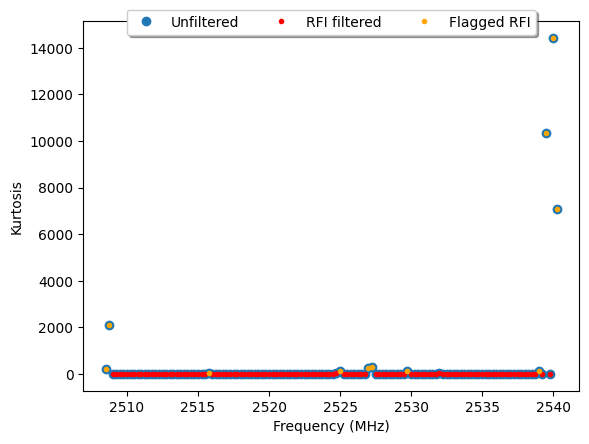

In [182]:
plot_mask_kurtosis(water6, n_divs=128, threshold=50, unfiltered=True, not_rfi=True, rfi=True)

In [168]:
plt.close('all')

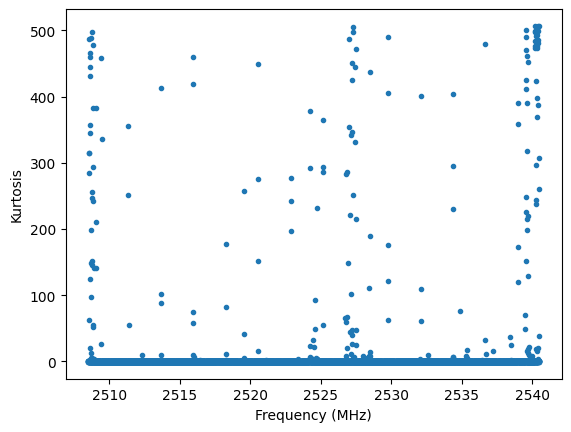

In [49]:
plot_tavg_kurtosis(water6, 8192)

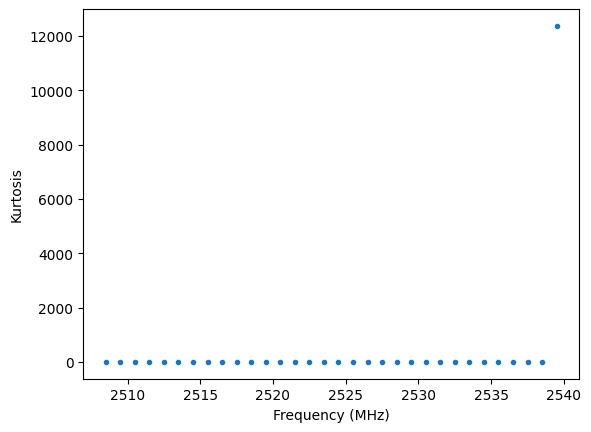

In [46]:
# kurts1 = plot_tavg_kurtosis(water6, 8192)
kurts2 = plot_tavg_kurtosis(water6, 32)

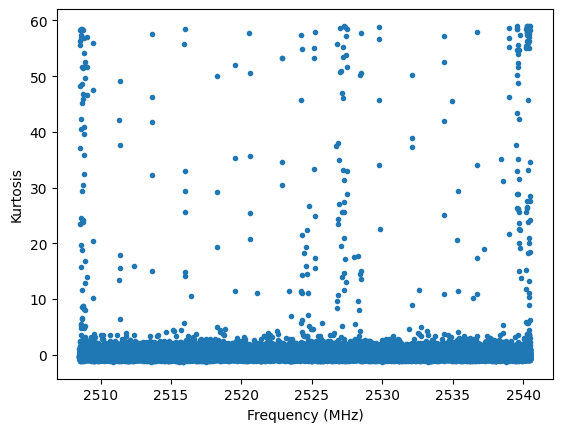

In [43]:
# kurts1 = plot_tavg_kurtosis(water6, 8192)
kurts2 = plot_tavg_kurtosis(water6, 2**16)

Where is kurtosis non-finite: (1, 40), (array([  29,   37,   43, ..., 8186, 8188, 8190]),)
Non-scaled kurtosis length: (1, 8152)
Scaled kurtosis length: (8192,)
Infinite kurtosis length: (1, 40)


(array([ 0.04330681, -0.00755788, -0.22072963, ...,  0.39160954,
                inf,  0.18960121]),
 (array([  29,   37,   43, ..., 8186, 8188, 8190]),))

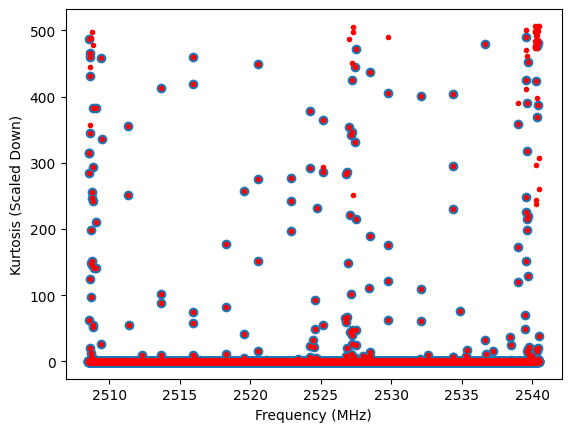

In [40]:
plot_tavg_kurtosis_scale(water6, 8192)

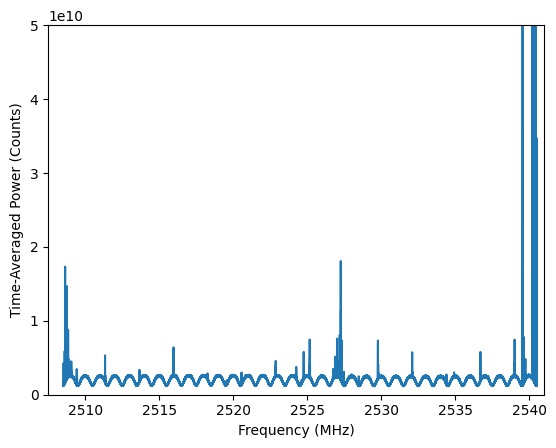

In [12]:
plot_tavg_power(water6, f_start=2507.5, f_stop=2541, find_inf=False, n_divs=8192)

In [8]:
t0 = time.time()
n_divs = 32
all_sig_kurts = []
all_sig_freqs = []
pltdata = []

wf_n = np.array_split(water6.get_freqs(), n_divs) # Split wf into (n_divs) divisions
for division in wf_n:
    f_start = np.amin(division)
    f_stop = np.amax(division)
    
    plot_f, plot_data = water6.grab_data(f_start, f_stop, if_id=0)
    
    # Using accending frequency for all plots.
    if water6.header['foff'] < 0:
            plot_data = plot_data[..., ::-1]  # Reverse data
            plot_f = plot_f[::-1]
            
    print(type(plot_data))
    print(np.shape(plot_data))
    
    pltdata.append(kurtosis(plot_data, axis=0, nan_policy='omit'))
    try:
        print(np.shape(pltdata))
    except:
#         print(np.shape(pltdata))
        print("The shape of pltdata is now inhomogeneous")
    
    # Add kurtoses with Pearson kurt() > 0 to an array
#     all_sig_kurts.append(pltdata[np.where(pltdata[0] > 0)])
    
    # Make sure you use plot_f and NOT wf.get_freqs() because the order of wf.get_freqs() is decreasing,
    # but we want it to be increasing!
    
    # Add frequencies with Pearson kurt() > 0 to an array
#     all_sig_freqs.append(plot_f[np.where(pltdata[0] > 0)])
    
t1 = time.time()
print(f'Elapsed time: {t1 - t0}')

<class 'numpy.ndarray'>
(223, 131072)
(1, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(2, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(3, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(4, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(5, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(6, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(7, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(8, 131072)
<class 'numpy.ndarray'>
(223, 131072)
(9, 131072)
<class 'numpy.ndarray'>
(223, 131072)


KeyboardInterrupt: 

In [ ]:
# fig, ax = plt.subplots()

# ax.plot()

In [12]:
plt.close('all')